# Notebook to evaluate Sentinel-1 NRB sample product

In [ ]:
# from zipfile import ZipFile

# with ZipFile('Australia_SH_2019.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in current directory
#    zipObj.extractall()

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import os, glob
from matplotlib import pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.colors import LogNorm

## Load Sentinel-1 NRB sample product over Australian corner reflector site

### Load S1 sample data

In [2]:
# sinergise sample

def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/**/*{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        date = np.datetime64('-'.join(fname.split('/')[-1].split('/')[-1].split('_')[4:7]))
        data.append(xr.open_rasterio(fname).squeeze().to_dataset(name=band).expand_dims({'time':[date]}))
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby('time')

In [3]:
bands = ['HH', 'AREA', 'ANGLE', 'MASK']

In [4]:
#combined = xr.combine_by_coords([load_s1_sample_combined('s1_sample_cr/s1_nrb', band) for band in bands])

In [5]:
combined_norm_bilinear = xr.combine_by_coords([load_s1_sample_combined('s1_sample_cr/s1_nrb_bilinear/', band) for band in bands])

In [6]:
combined_bilinear_norm = xr.combine_by_coords([load_s1_sample_combined('s1_sample_cr/s1_nrb_bilinear_norm/', band) for band in bands])

In [7]:
combined_norm_bilinear.x.values - combined_bilinear_norm.x.values

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
sub1= combined_norm_bilinear.dropna('x', how='any').isel(x=slice(-500,-1)).isel(y=slice(-500,-1)).squeeze()
sub2= combined_bilinear_norm.sel(x=sub1.x.values,y=sub1.y.values).squeeze()

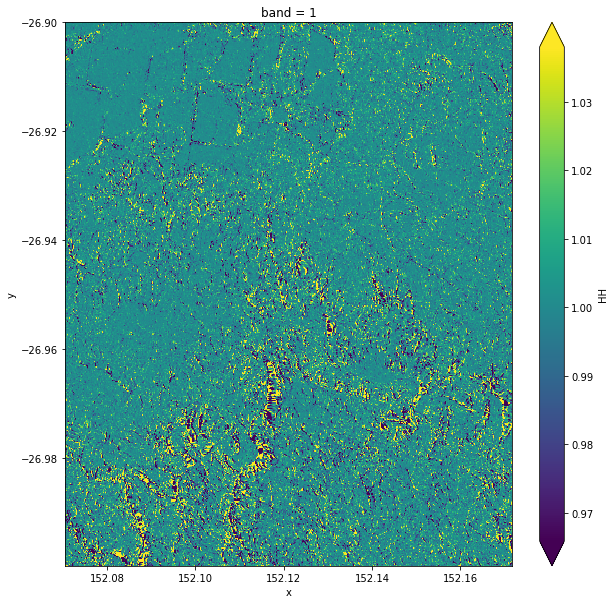

In [9]:
(sub1/sub2).HH.plot.imshow(robust=True, figsize=(10,10));

In [330]:
(sub1.HH/sub2.HH).mean().values, (sub1.HH/sub2.HH).max().values, 

(array(1.0014212, dtype=float32), array(2.04277921))

In [10]:
sub1_db = 10*np.log10(sub1.HH)
sub2_db = 10*np.log10(sub2.HH)

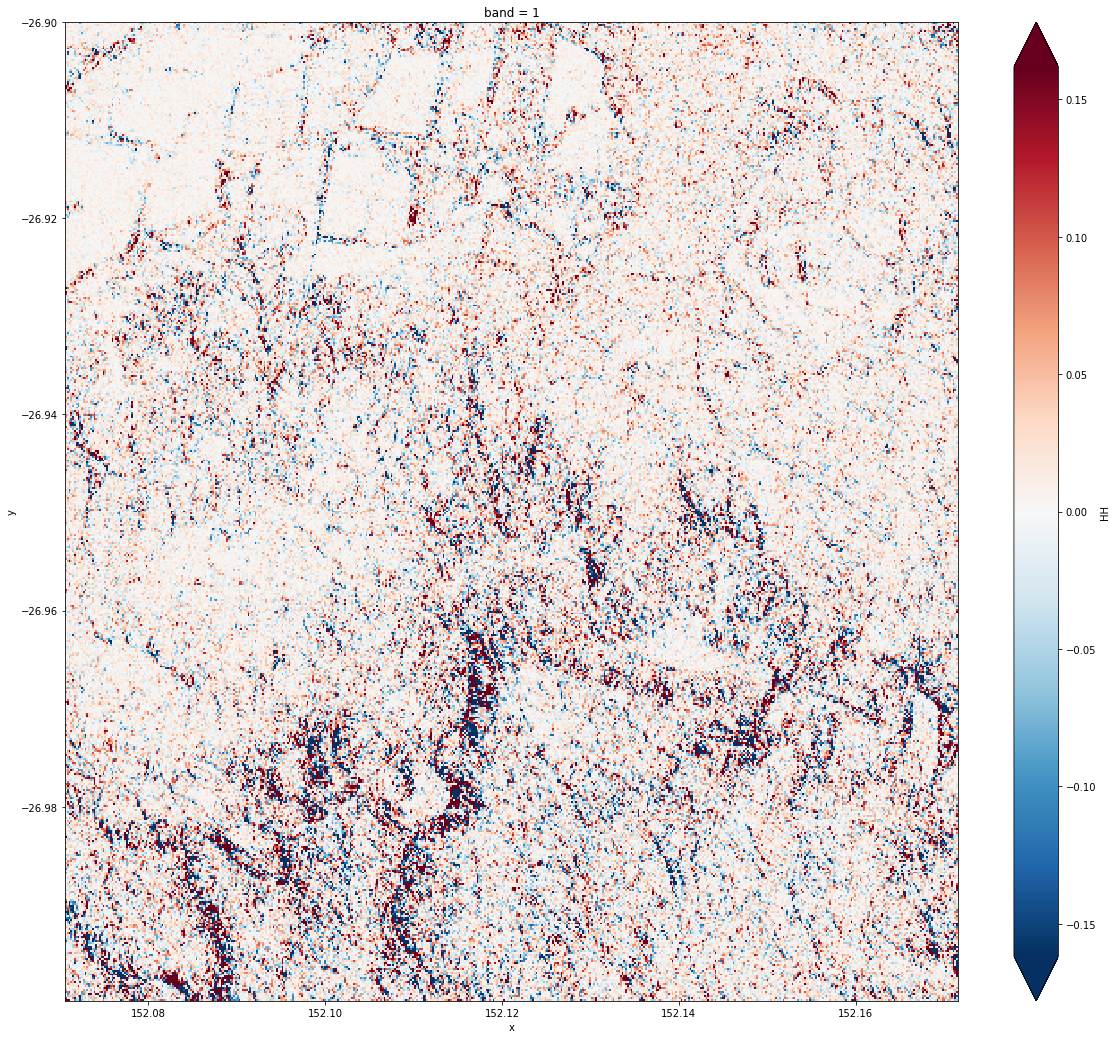

In [12]:
diff_db = (sub1_db-sub2_db)
diff_db.plot.imshow(robust=True, figsize=(20,18));

In [388]:
dev = (np.abs(diff_db)>0.2)
dev.mean().values

array(0.02494769)

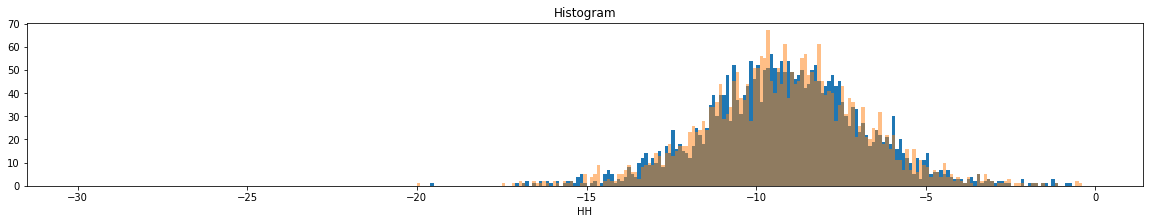

In [337]:
(sub1_db.where(dev)).plot.hist(bins=np.arange(-30,0,0.1), figsize=(20,3));
(sub2_db.where(dev)).plot.hist(bins=np.arange(-30,0,0.1), alpha=0.5);

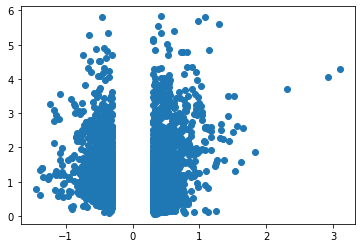

In [338]:
plt.scatter(diff_db.where(dev).values, sub1.AREA.where(dev).values)

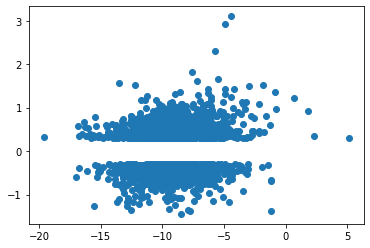

In [340]:
plt.scatter(sub1_db.where(dev).values, diff_db.where(dev).values)

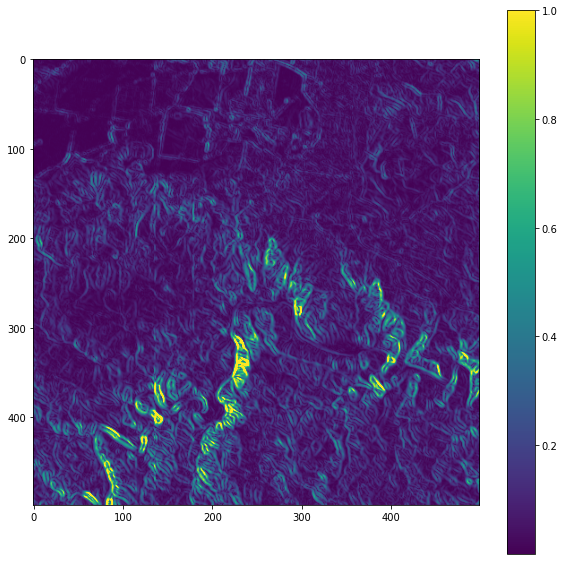

In [13]:
from skimage import filters

edge_sobel = filters.sobel(sub1.AREA.values)
plt.figure(figsize=(10,10));
plt.imshow(edge_sobel, vmax=1);
plt.colorbar();

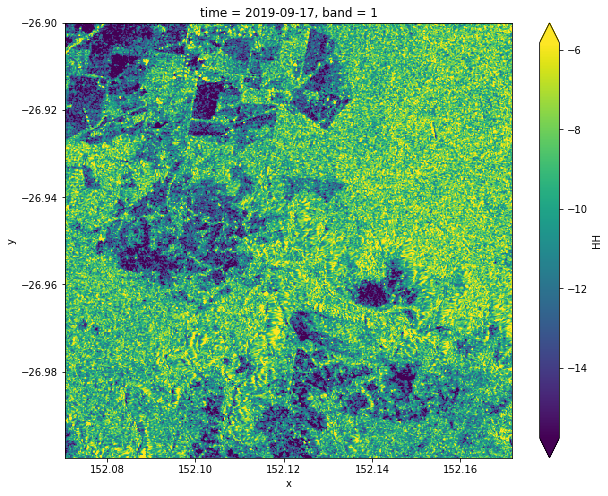

In [14]:
sub1_db.plot.imshow(robust=True, figsize=(10,8));

In [15]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

sub1_db_filtered = 10*np.log10(lee_filter(sub1.HH, 7))
sub2_db_filtered = 10*np.log10(lee_filter(sub2.HH, 7))


In [16]:
np.mean((sub1_db_filtered<-12.)*1-(sub2_db_filtered<-12.)*1)

-0.00021686659892932158

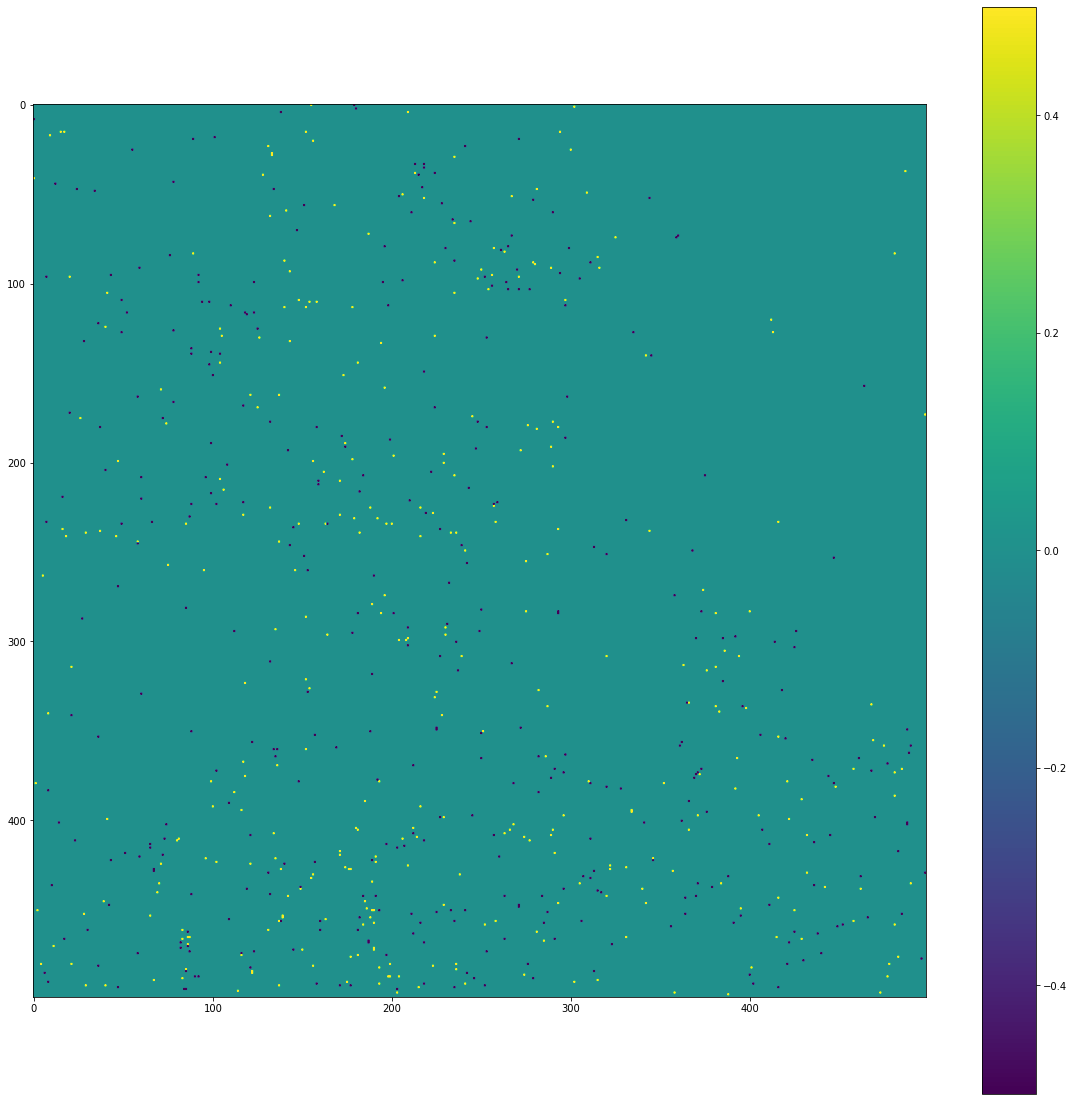

In [27]:
th =-12
plt.figure(figsize=(20,20))
plt.imshow((sub1_db<th)*1 - (sub2_db<th)*1, vmin=-0.5, vmax=0.5);
plt.colorbar();

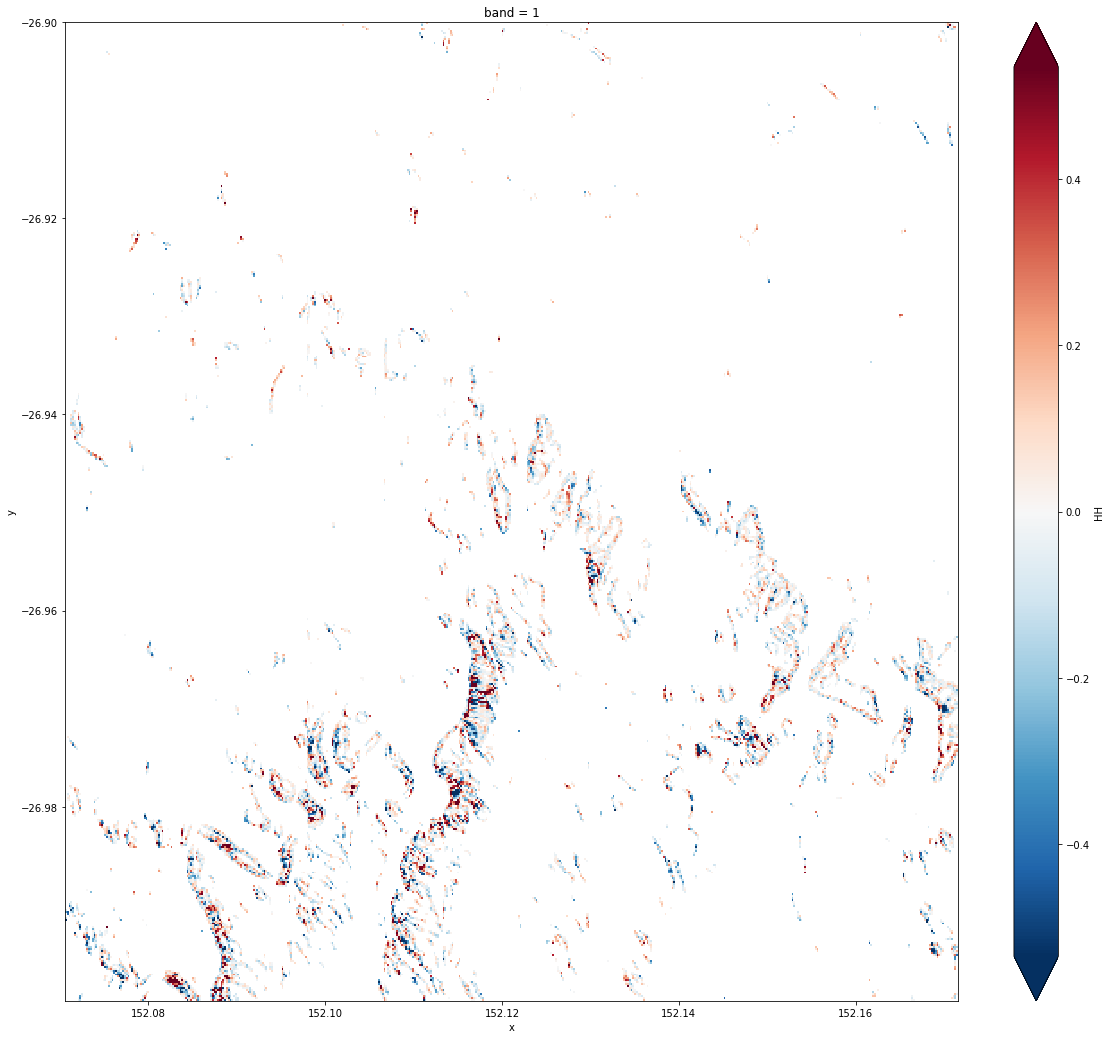

In [20]:
diff_db.where(edge_sobel>0.3).plot.imshow(robust=True, figsize=(20,18));

In [17]:
10**(-22./10)

0.00630957344480193

/env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


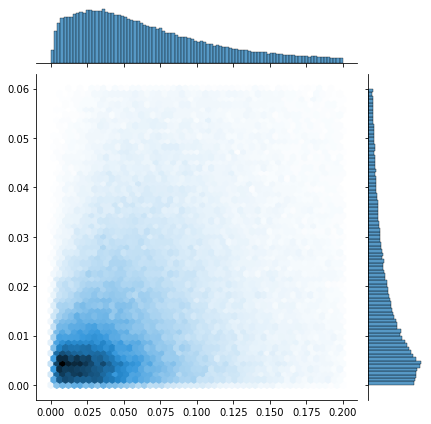

In [385]:
#plt.scatter(edge_sobel, abs(diff_db).values);
import seaborn
arr1 = edge_sobel.flatten()
arr2 = np.abs(diff_db.values.flatten())
ind = (arr1<0.2) & (arr2<0.06)
seaborn.jointplot(arr1[ind], arr2[ind], kind='hex');

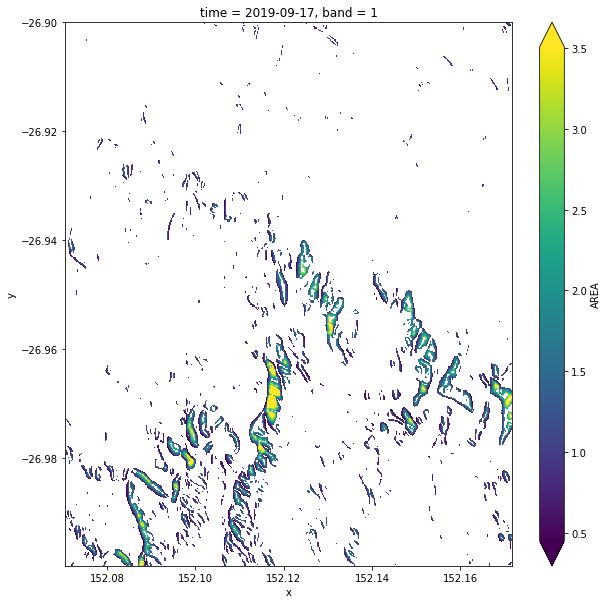

In [348]:
(sub1.AREA.where(edge_sobel>0.3)).plot.imshow(robust=True, figsize=(10,10));

In [ ]:
#combined.MASK.squeeze().plot.imshow(robust=True, figsize=(10,10));

In [ ]:
#(combined.ANGLE*254.55/360).where(combined.ANGLE<255).squeeze().plot.imshow(robust=True, figsize=(10,10));

In [ ]:
#combined.AREA.squeeze().plot.imshow(robust=True, figsize=(10,10));

### Load CR locations

In [96]:
import pandas as pd

In [97]:
!ls ~/dev/SAR/

QLD_corner_reflector_positions_GDA2020.txt   SAR_ARD
QLD_corner_reflector_positions_GDA2020.xlsx


In [98]:
cr_locations = pd.read_csv('~/dev/SAR/QLD_corner_reflector_positions_GDA2020.txt', sep="\s+", header=0)

In [99]:
cr_locations.head()

,Name,Latitude,Longitude,Height,X,Y,Z,veloX,veloY,veloZ,Azimuth,Elevation
0,SB01-CRApex,-26.834710,151.165604,409.4544,-4.989394e+06,2.746844e+06,-2.862070e+06,-0.0325,-0.0083,0.0487,257.10,53.32
1,SB02-CRApex,-26.951633,151.237613,432.7094,-4.987723e+06,2.737762e+06,-2.873636e+06,-0.0325,-0.0082,0.0486,256.21,53.33
2,SB03-CRApex,-27.100732,151.258809,391.8599,-4.982121e+06,2.732289e+06,-2.888335e+06,-0.0326,-0.0081,0.0485,258.46,54.34
3,SB04-CRApex,-27.308871,151.271959,385.2420,-4.973496e+06,2.726074e+06,-2.908845e+06,-0.0326,-0.0079,0.0484,258.51,54.67
4,SB05-CRApex,-27.456930,151.190830,403.0057,-4.963033e+06,2.729485e+06,-2.923422e+06,-0.0327,-0.0077,0.0484,258.20,55.36


In [100]:
col_lat = [n for n in list(cr_locations.columns) if 'Latitude' in n]
col_lon = [n for n in list(cr_locations.columns) if 'Longitude' in n]

In [101]:
cr_locations= cr_locations[cr_locations[col_lat].notnull().values & cr_locations[col_lon].notnull().values]

In [102]:
len(cr_locations)

40

In [105]:
s1 = combined.HH.squeeze()

In [106]:
hs = 0.0008

data_crs = []
for idx, row in cr_locations.iterrows():
    try:
        # is the CR in the scene?
        d = s1.sel(x = row[col_lon].values[0], y = row[col_lat].values[0], method='nearest', tolerance=0.002)
        x0, y0 = d.x.values, d.y.values
        #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
        # is it visible?
        peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
        if peak.max()>3: 
            #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
            data_crs.append(data)
        else:
            print("not visible?", peak.max().values)
    except KeyError:
        pass
    # 

In [107]:
len(data_crs)

0

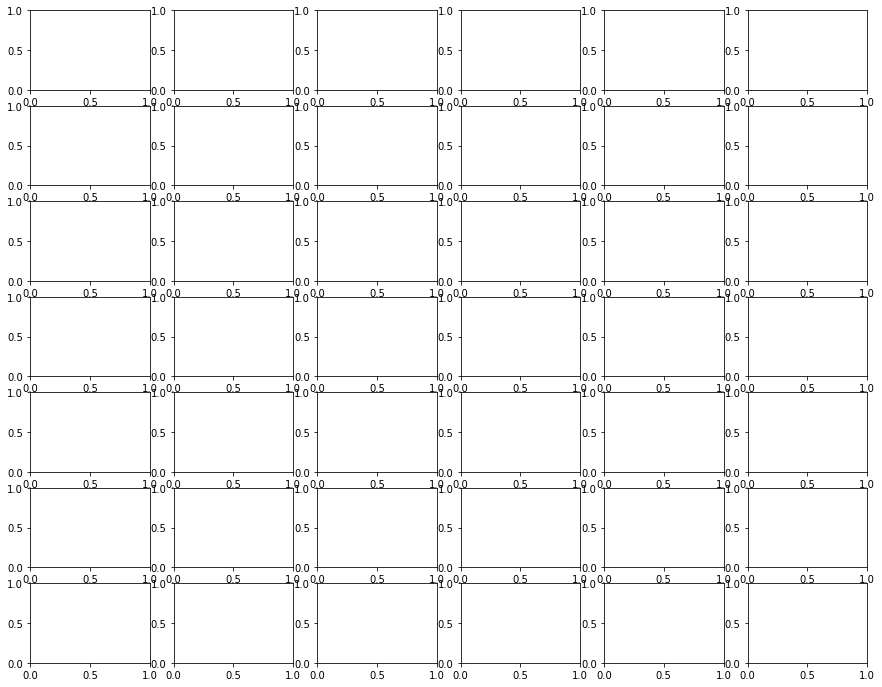

In [108]:
f, ax = plt.subplots(7,6,figsize=(15,12))
ax = ax.flatten()
for i in range(len(data_crs)):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.5, vmax=2);

### Find peak backscatter in each stamp around a CR

In [112]:
!pip install photutils

  Using cached photutils-1.0.1-cp36-cp36m-manylinux2010_x86_64.whl (789 kB)


In [113]:
from photutils.centroids import centroid_2dg

In [114]:
from scipy import interpolate
from scipy import ndimage

In [115]:
ps = 0.0002 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
#111.32*1000*0.0002*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) for minimum meter per degree lon

In [116]:
# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print(np.sqrt(np.mean((cr_locations.Latitude.values - c_lats)**2))/ps, np.sqrt(np.mean((cr_locations.Longitude.values - c_lons)**2))/ps)    
print(np.sqrt(np.mean((cr_locations.Latitude.values - c_lats)**2))*mpd_lat, np.sqrt(np.mean((cr_locations.Longitude.values - c_lons)**2))*mpd_lon)

ValueError: operands could not be broadcast together with shapes (40,) (0,) 

ValueError: operands could not be broadcast together with shapes (40,) (0,) 

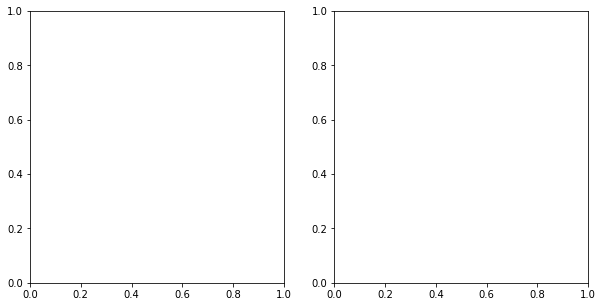

In [117]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((cr_locations.Latitude.values - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[1].hist((cr_locations.Longitude.values - c_lons)/ps, bins=np.arange(-1,1,0.1));

In [ ]:
# center of mass high backscatter pixels

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = ndimage.measurements.center_of_mass(data_crs[i].where(data_crs[i]>1,0).values)
    c_lon, c_lat = fx(x), fy(y)

    c_lats.append(c_lat)
    c_lons.append(c_lon)

    
print(np.sqrt(np.mean((cr_locations.Latitude.values - c_lats)**2))/ps, np.sqrt(np.mean((cr_locations.Longitude.values - c_lons)**2))/ps)    
print(np.sqrt(np.mean((cr_locations.Latitude.values - c_lats)**2))*mpd_lat, np.sqrt(np.mean((cr_locations.Longitude.values - c_lons)**2))*mpd_lon)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((cr_locations.Latitude.values - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[1].hist((cr_locations.Longitude.values - c_lons)/ps, bins=np.arange(-1,1,0.1));

In [ ]:
# gaussian centroid 

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # gaussian centroid
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = centroid_2dg(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

    
print(np.sqrt(np.mean((cr_locations.Latitude.values - c_lats)**2))/ps, np.sqrt(np.mean((cr_locations.Longitude.values - c_lons)**2))/ps)    
print(np.sqrt(np.mean((cr_locations.Latitude.values - c_lats)**2))*mpd_lat, np.sqrt(np.mean((cr_locations.Longitude.values - c_lons)**2))*mpd_lon)

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((cr_locations.Latitude.values - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[1].hist((cr_locations.Longitude.values - c_lons)/ps, bins=np.arange(-1,1,0.1));